<h1>Minimal MNIST demo</h1>
This notebook showcases some of the tensorflow-like syntax and capabilities of ntb by fitting a subset of MNIST.

In [1]:
from ntb.datasets import mnist
import ntb
import numpy as np

%matplotlib inline

In [2]:
#the loader returns
#(1) a data dict with keys 'X_train, 'X_val', 'y_train', 'y_val'
#which correspond to training set and validation set images and labels
#(2) a visualization routine, showing a few examples

data,vis = mnist.load(mode="1d",num_train=6000,num_val=1000)

In [3]:
#a simple neural network with 1 hidden layer

num_hidden = 50

#we construct a computational graph
graph = ntb.ComputationGraph()

#and set it as default (otherwise it would have to be specified for all the input nodes)
with ntb.default_graph(graph):
    #first we define a few placeholder nodes to assign values to during training and prediction
    #when specifying the shape of a node, a -1 in any dimension will function as a wildcard 
    x = ntb.Placeholder(shape=[-1,28*28]) #input placeholder for the images
    y = ntb.Placeholder(shape=[-1]) #input placeholder for the labels
    lr = ntb.Placeholder() #placeholder for the learning rate
    reg = ntb.Placeholder() #placeholder for l2 regularization strength
    
    #create an affine transformation
    #w1 and b1 are the learnable weights and biases, aff the output node
    aff,w1,b1 = ntb.affine_layer(x,num_hidden)
    
    #followed by a sigmoid nonlinearity
    hid = ntb.Sigmoid(aff)
    
    #from this we calculate logit scores (1 per class, i.e. 10)
    scores,w2,b2 = ntb.affine_layer(hid,10)
    
    #and finally the loss function
    #(cross entropy loss plus l2 weight decay loss for the 2 weights)
    loss = ntb.CrossEntropyLogits(scores,y)+reg*ntb.L2(w1,w2)
    
    #the resulting predicted classes and accuracy
    pred = ntb.Argmax(scores,axis=1)
    acc = ntb.Equals(pred,y).mean(axis=0)
    
    #we add an optimization node, which will apply gradient descent with momentum
    #to all learnable parameters (w1,b1,w2,b2) to minimize the loss
    optim = ntb.Optim(loss,lr=lr,update_rule='sgd')

In [4]:
#we now fit the net on the first 6000 images of MNIST

iterations = 500
print_every = 100
reg_strength = 1e-2
learning_rate = 4e-2

for i in range(iterations+1):
    
    #we let the graph calculate the loss and accuracy and run the optimization node
    #we assign images and labels to the x and y placeholder nodes,
    #learning rate and regularization strength to lr and reg respectively
    
    l,a,_ = graph.run([loss,acc,optim],
                         assign_dict={x:data['X_train'],
                                      y:data['y_train'],
                                      lr:learning_rate,reg:reg_strength})
    
    #intermittently we print the training and validation loss
    
    if i%print_every == 0:
        
        vl,va = graph.run([loss,acc],{x:data['X_val'],
                                      y:data['y_val'],
                                      reg:reg_strength})
        
        print("\nTrain loss %.4f" % l,
              "Train accuracy %.4f" % a)
        
        print("Validation loss %.4f" % vl,
              "Validation accuracy %.4f" % va)


Train loss 3.1218 Train accuracy 0.0950
Validation loss 2.9881 Validation accuracy 0.1200

Train loss 0.7784 Train accuracy 0.9288
Validation loss 0.8575 Validation accuracy 0.8950

Train loss 0.5699 Train accuracy 0.9500
Validation loss 0.6672 Validation accuracy 0.9090

Train loss 0.4812 Train accuracy 0.9580
Validation loss 0.5948 Validation accuracy 0.9120

Train loss 0.4068 Train accuracy 0.9740
Validation loss 0.5459 Validation accuracy 0.9210

Train loss 0.3801 Train accuracy 0.9812
Validation loss 0.5342 Validation accuracy 0.9190


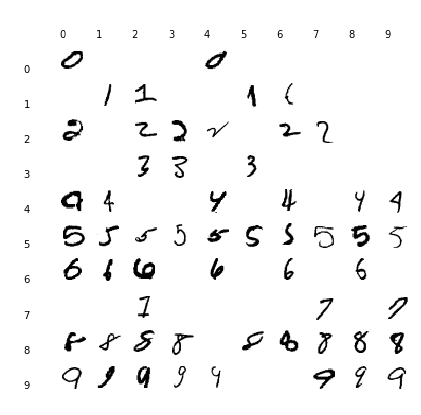

In [5]:
#let's show a few examples of what the net got wrong (and right)
#rows correspond to correct classes, columns to what the network guessed

predict = lambda X:graph.run([pred],assign_dict={x:X})[0]
ntb.datasets.vis.render_confusion_sample(data,pred_fn=predict,cmap='gray_r',figsize=(7.0,7.0))